In [1]:
# importing the libraries
import numpy as np
import peakutils
import syntheticdata
import threegaussians
import lorentzian
from peakutils.plot import plot as pplot
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from scipy import interpolate
from astropy.modeling import models, fitting
import pandas as pd

In [2]:
def plot_peaks_lows_highs(x, highs, lows, algorithm=None, mph=None, mpd=None):
    """Plot results of the peak dectection."""
    
    _, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(x, 'b', lw=1)
    if highs.size:
        label = 'high peak'
        label = label + 's' if highs.size > 1 else label
        ax.plot(highs, x[highs], '+', mfc=None, mec='r', mew=2, ms=8,
                label='%d %s' % (highs.size, label))
        ax.legend(loc='best', framealpha=.5, numpoints=1)
    if lows.size:
        label = 'low peak'
        label = label + 's' if lows.size > 1 else label
        ax.plot(lows, x[lows], '+', mfc=None, mec='g', mew=2, ms=8,
                label='%d %s' % (lows.size, label))
        ax.legend(loc='best', framealpha=.5, numpoints=1)
    ax.set_xlim(-.02*x.size, x.size*1.02-1)
    ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
    yrange = ymax - ymin if ymax > ymin else 1
    ax.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
    ax.set_xlabel('Data #', fontsize=14)
    ax.set_ylabel('Amplitude', fontsize=14)
    ax.set_title('%s (mph=%s, mpd=%s)' % (algorithm, mph, mpd))
    plt.show()


## Try to find minimum peak values in the two gaussian dataset

In [12]:
# load some data
def loaddata(data_filename):
    """load matrix data"""
    data = np.genfromtxt(data_filename, delimiter='\t')
    data_nm = data[1:,0]    #wavelength in nm
    data_time = data[0,1:]
    data_z = data[1:, 1:]

    return data_nm, data_time, data_z

In [14]:
matx_filename = '20180418_twogaussian_spectralshfit.txt'
datanm, datatime, dataz_matx = loaddata(matx_filename)

Detect high peaks with minimum height and distance filters.
High peaks are: [ 50 400]
Detect low peaks with minimum height and distance filters.
Low peaks are: [197]


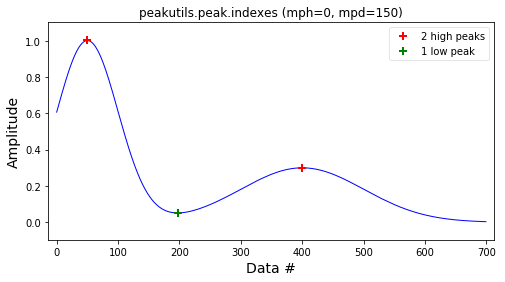

In [15]:
threshold = 0
min_dist = 150
data_z_array = dataz_matx[:,0]

print('Detect high peaks with minimum height and distance filters.')
highs = peakutils.indexes(
    data_z_array,
    thres=threshold, min_dist=min_dist
)
print('High peaks are: %s' % (highs))

print('Detect low peaks with minimum height and distance filters.')
# Invert the signal.
data_z_arrayInverted = data_z_array * -1
lows = peakutils.indexes(
    np.array(data_z_arrayInverted),
    thres=threshold, min_dist=min_dist
)
print('Low peaks are: %s' % (lows))

plot_peaks_lows_highs(
    data_z_array,
    highs,
    lows,
    mph=threshold, mpd=min_dist, algorithm='peakutils.peak.indexes'
)

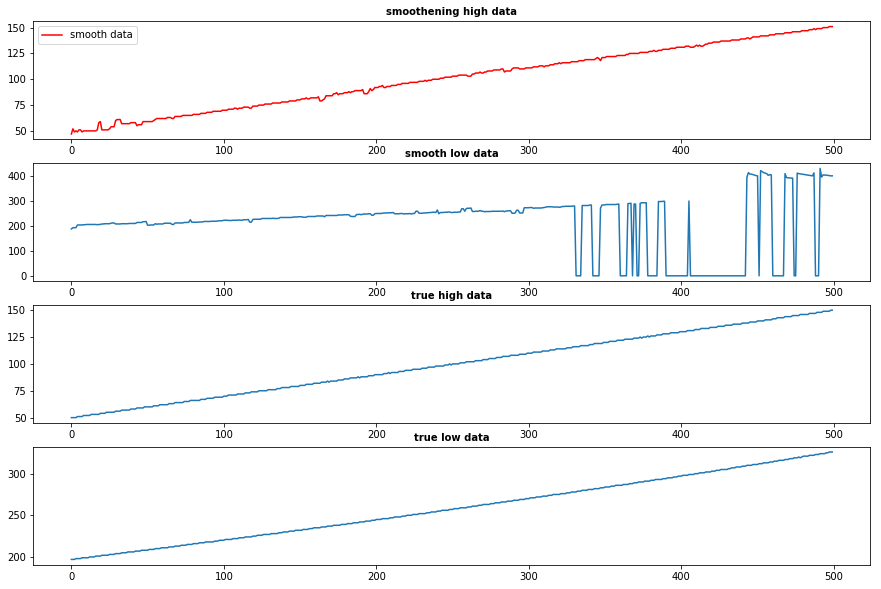

In [91]:
smooth_high_array=smooth_high_df.iloc[:,0].values
smooth_low_array=smooth_low_df.iloc[:,0].values
true_high_array=true_high_df.iloc[:,0].values
true_low_array=true_low_df.iloc[:,0].values

# plot the noise data curve and denoise curve
plt.figure(figsize=(15,10))
plt.subplot(411)
plt.title('smoothening high data', fontsize = 10, fontweight = 'bold')
plt.plot(smooth_high_array, color='red',markersize = 20, label = 'smooth data')
plt.legend()


plt.subplot(412)
plt.title('smooth low data', fontsize = 10, fontweight = 'bold')
plt.plot(smooth_low_array,markersize = 20, label = 'true data')

plt.subplot(413)
plt.title('true high data', fontsize = 10, fontweight = 'bold')
plt.plot(true_high_array,markersize = 20, label = 'true data')


plt.subplot(414)
plt.title('true low data', fontsize = 10, fontweight = 'bold')
plt.plot(true_low_array,markersize = 20, label = 'true data')




In [67]:
def earth_peak_matrix(nm_array,data_matrix,threshold, min_dist):
    num_array = np.shape(data_matrix)[1]
    smooth_high_peak = []
    true_high_peak = []
    smooth_low_peak = []
    true_low_peak = []
    
    for i in range(num_array):
        data_array = data_matrix[:, i]
        smooth_array = earth_Smoothing(nm_array, data_array)
        
        highs = peakutils.indexes(smooth_array, thres=threshold, min_dist=min_dist)
        smooth_high_peak.append(highs)
        highs = peakutils.indexes(data_array, thres=threshold, min_dist=min_dist)
        true_high_peak.append(highs)

        data_z_arrayInverted = smooth_array * -1
        lows = peakutils.indexes(
            np.array(data_z_arrayInverted),
            thres=threshold, min_dist=min_dist
        )
        smooth_low_peak.append(lows)
        
        data_z_arrayInverted = data_array * -1
        lows = peakutils.indexes(
            np.array(data_z_arrayInverted),
            thres=threshold, min_dist=min_dist
        )
        true_low_peak.append(lows)

        # transfer to dataframe
        true_high_df=pd.DataFrame(true_high_peak)
        true_high_df=true_high_df.fillna(0)
        
        # transfer to dataframe
        true_low_df=pd.DataFrame(true_low_peak)
        true_low_df=true_low_df.fillna(0) 

        # transfer to dataframe
        smooth_high_df=pd.DataFrame(smooth_high_peak)
        smooth_high_df=smooth_high_df.fillna(0)
        
        # transfer to dataframe
        smooth_low_df=pd.DataFrame(smooth_low_peak)
        smooth_low_df=smooth_low_df.fillna(0)      
    
    return smooth_high_df,true_high_df,smooth_low_df,true_low_df

In [70]:
smooth_high_df,true_high_df,smooth_low_df,true_low_df = earth_peak_matrix(datanm,dataz_matx,0, 100)

/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [79]:
len(datanm)

700

In [ ]:
threshold = 0
min_dist = 150
data_z_array = dataz_matx[:,0]

print('Detect high peaks with minimum height and distance filters.')
highs = peakutils.indexes(
    data_z_array,
    thres=threshold, min_dist=min_dist
)
print('High peaks are: %s' % (highs))

print('Detect low peaks with minimum height and distance filters.')
# Invert the signal.
data_z_arrayInverted = data_z_array * -1
lows = peakutils.indexes(
    np.array(data_z_arrayInverted),
    thres=threshold, min_dist=min_dist
)
print('Low peaks are: %s' % (lows))

plot_peaks_lows_highs(
    data_z_array,
    highs,
    lows,
    mph=threshold, mpd=min_dist, algorithm='peakutils.peak.indexes'
)

In [65]:
# add noise
def add_noise(nm_array, y_array, noise_coefficient):
    # Add noise
    np.random.seed(1800)
    y_noise = noise_coefficient * np.random.normal(size=nm_array.size)
    y_proc = y_array + y_noise
    
    return y_proc

## Try to find minimum peak values in the real TA dataset

In [5]:
def loaddata(tadata_filename):
    tadata = np.genfromtxt(tadata_filename, delimiter=',', skip_footer = 16)
    tadata_z = tadata[1:,1:]
    tadata_timedelay = tadata[0,1:]  #timedelay in ps
    tadata_timedelay = np.nan_to_num(tadata_timedelay)
    tadata_nm = tadata[1:,0]  #wavelength in nm
    tadata_nm = np.nan_to_num(tadata_nm)
    tadata_z_corr = np.empty((len(tadata_nm), len(tadata_timedelay)))
    tadata_z_corr = np.nan_to_num(tadata_z)
    return tadata, tadata_timedelay, tadata_nm, tadata_z_corr

In [6]:
tadata_filename = 'exp03_20180103 -t0 -chirp.csv'
tadata, tadata_timedelay, tadata_nm, tadata_z_corr=loaddata(tadata_filename)

In [9]:
data_z_array=tadata_z_corr[:,50]

* before smoothing TA data

Detect high peaks with minimum height and distance filters.
High peaks are: [ 27 254]
Detect low peaks with minimum height and distance filters.
Low peaks are: [ 19 234]


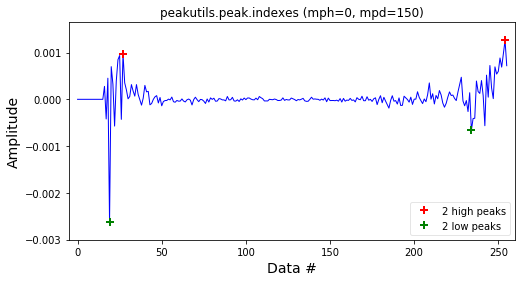

In [10]:
threshold = 0
min_dist = 150

print('Detect high peaks with minimum height and distance filters.')
highs = peakutils.indexes(
    data_z_array,
    thres=0, min_dist=150
)
print('High peaks are: %s' % (highs))

print('Detect low peaks with minimum height and distance filters.')
# Invert the signal.
data_z_arrayInverted = data_z_array * -1
lows = peakutils.indexes(
    np.array(data_z_arrayInverted),
    thres=0, min_dist=150
)
print('Low peaks are: %s' % (lows))

plot_peaks_lows_highs(
    data_z_array,
    highs,
    lows,
    mph=threshold, mpd=min_dist, algorithm='peakutils.peak.indexes'
)

In [42]:
def earth_Smoothing(nm_array, y_array):        

    from pyearth import Earth
   # Fit an Earth model
    model = Earth(smooth=True) 
    model.fit(nm_array, y_array)

   # Print the model
    #print(model.trace())
    #print(model.summary())

   # Get the predicted values and derivatives
    y_hat = model.predict(nm_array)
    
    return  y_hat

In [43]:
def earth_smooth_matrix(nm_array,data_matrix):
    num_array = np.shape(data_matrix)[0]   
    smooth_matx = pd.DataFrame(np.empty((num_array,1)), columns = ['a'])
    
    for i in range(data_matrix.shape[1]):
        data_array = data_matrix[:, i]       
        # get noise and smooth list
        smooth_array =earth_Smoothing(nm_array,data_array).tolist()
        
        # get smooth dataframe
        df = pd.DataFrame(smooth_array,columns = [i])
        smooth_matx = smooth_matx.join(df)
        
    # drop the first columns  
    smooth_matx = smooth_matx.drop(columns='a')
        
    return smooth_matx

In [23]:
def findpeak(data_z_array, threshold, min_dist):
    """find peaks and return indices of the peaks"""    
    peak_indices = peakutils.indexes(data_z_array, thres=threshold, min_dist=min_dist)   
    return peak_indices

In [44]:
smooth_matx1 = earth_smooth_matrix(tadata_nm,tadata_z_corr)

/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Detect high peaks with minimum height and distance filters.
High peaks are: [ 19 199]
Detect low peaks with minimum height and distance filters.
Low peaks are: [ 96 230]


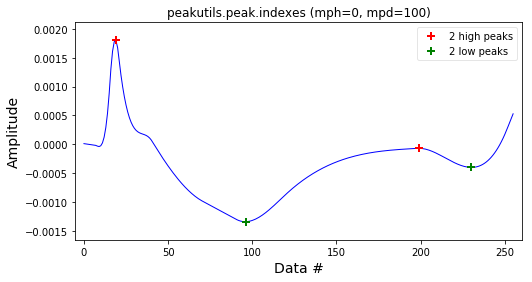

In [50]:
threshold = 0
min_dist = 100
data_z_array=smooth_matx1.iloc[:,300].values

print('Detect high peaks with minimum height and distance filters.')
highs = peakutils.indexes(
    data_z_array,
    thres=threshold, min_dist=min_dist
)
print('High peaks are: %s' % (highs))

print('Detect low peaks with minimum height and distance filters.')
# Invert the signal.
data_z_arrayInverted = data_z_array * -1
lows = peakutils.indexes(
    np.array(data_z_arrayInverted),
    thres=threshold, min_dist=min_dist
)
print('Low peaks are: %s' % (lows))

plot_peaks_lows_highs(
    data_z_array,
    highs,
    lows,
    mph=threshold, mpd=min_dist, algorithm='peakutils.peak.indexes'
)

In [21]:
def earth_peak_matrix(nm_array,data_matrix,threshold, min_dist):
    num_array = np.shape(data_matrix)[1]
    smooth_peak = [] 
    for i in range(num_array):
        data_array = data_matrix[:, i]
        smooth_array = earth_Smoothing(nm_array, data_array,0.1)        
        indexes1=findpeak(smooth_array, threshold, min_dist).tolist()
        smooth_peak.append(indexes1)
                
        # transfer to dataframe
        smooth_df=pd.DataFrame(smooth_peak)
        smooth_df=smooth_df.fillna(0)
    
    return smooth_df

In [24]:
smooth_df1 = earth_peak_matrix(tadata_nm, tadata_z_corr, 0, 10)

/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [55]:
def earth_peak_matrix(nm_array,data_matrix,threshold, min_dist):
    num_array = np.shape(data_matrix)[1]
    smooth_high_peak = []
    smooth_low_peak = []
    
    for i in range(num_array):
        data_array = data_matrix[:, i]
        smooth_array = earth_Smoothing(nm_array, data_array)
        
        highs = peakutils.indexes(smooth_array, thres=threshold, min_dist=min_dist)
        smooth_high_peak.append(highs)

        data_z_arrayInverted = smooth_array * -1
        lows = peakutils.indexes(
            np.array(data_z_arrayInverted),
            thres=threshold, min_dist=min_dist
        )
        smooth_low_peak.append(lows)
   
        # transfer to dataframe
        smooth_high_df=pd.DataFrame(smooth_high_peak)
        smooth_high_df=smooth_high_df.fillna(0)
        
        # transfer to dataframe
        smooth_low_df=pd.DataFrame(smooth_low_peak)
        smooth_low_df=smooth_low_df.fillna(0)      
    
    return smooth_high_df, smooth_low_df

In [56]:
smooth_high_df, smooth_low_df = earth_peak_matrix(tadata_nm, tadata_z_corr, 0, 100)

/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/tutu/miniconda3/lib/python3.6/site-packages/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


## output maximum peak values

In [57]:
smooth_high_df

,0,1,2
0,197.0,0.0,0.0
1,0.0,0.0,0.0
2,28.0,133.0,252.0
3,19.0,0.0,0.0
4,0.0,0.0,0.0
5,0.0,0.0,0.0
6,0.0,0.0,0.0
7,23.0,163.0,0.0
8,124.0,0.0,0.0
9,127.0,0.0,0.0


## output minimum peak values

In [58]:
smooth_low_df

,0,1
0,129.0,245.0
1,188.0,0.0
2,14.0,231.0
3,7.0,229.0
4,203.0,0.0
5,203.0,0.0
6,198.0,0.0
7,90.0,210.0
8,194.0,0.0
9,199.0,0.0
